# CS452/CS552 Assignment 2: Car Rollover Prediction

**Release Date: 23.11.2021** <br>
**Submission Deadline: 12.12.2021 23.55**

In [ ]:
# Author: Tuna Tuncer
# Department: Computer Science
# Degree: BSc.

In [1]:
# CELL NO 1
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests as rq
import io
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, chi2, f_regression

pd.set_option('display.max_columns', 150)
random.seed(42) # DO NOT CHANGE
np.random.seed(42) # DO NOT CHANGE

# Part 1: Data Loading and Cleaning
> Get FARS datasets through the API provided by NHTSA using requests library.<br>

Two types of datasets will be used in the project:<br>
*person* dataset provides the information of persons involved in a crash.<br>
*vindecode* dataset the information of vehicles involved in a crash thanks to decoded Vehicle Identification Number (VIN).

### 1.1 Data Loading

In [ ]:
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData"
case_years = np.arange(2014, 2020, dtype=int) # DO NOT CHANGE

In [ ]:
def get_persons_data(year):
    response = rq.get(url = api, params = {'dataset':'person', 'caseYear':year, 'format':'csv'})

    if response.ok:
        csv_data = response.content
        persons = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
        return persons
    
    print("Failed to get the data")
    print(response.status)
    
    return None

def get_vehicles_data(year):
    response = rq.get(url = api, params = {'dataset':'vindecode', 'caseYear':year, 'format':'csv'})

    if response.ok:
        csv_data = response.content
        vehicles = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
        return vehicles
    
    print("Failed to get the data")
    print(response.status)
    
    return None

1.1) Use the above methods to get vehicles and persons datasets from 2014 to 2019.

In [ ]:
# Fetch data from the person and vindecode APIs.
person_df = pd.DataFrame()  
for year in case_years:
    person_df = person_df.append(get_persons_data(year), ignore_index = True)
print("Person df shape:", person_df.shape)

vehicle_df = pd.DataFrame()  
for year in case_years:
    vehicle_df = vehicle_df.append(get_vehicles_data(year), ignore_index = True)
print("Vehicle df shape:", vehicle_df.shape)

In [ ]:
person_df = pd.read_csv("person.csv")
vehicle_df = pd.read_csv("vehicle.csv")

In [ ]:
# Print the shapes of the data frames.
print("Person df shape:", person_df.shape)
print("Vehicle df shape:", vehicle_df.shape)

In [ ]:
# See the head of the person dataframe
person_df.head()

In [ ]:
# See the head of the vehicle dataframe
vehicle_df.head()

### 1.2 Data Cleaning

1.2) Determine the useless columns to drop from the dataframes.

**Hint 1**: An encoded and a decoded (actual-valued) column exist for most of the features. Drop the encoded columns.<br>
**Hint 2**: Some features have mostly null values or a single value. <br>
**Hint 3**: Some features provides information that can be obtained after the accident. <br>
You can refer to [FARS User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813023) if needed.

In [ ]:
# Removing the person types that are not driver.
person_shape = person_df.shape
person_filter = person_df['per_typname'] != 'Driver of a Motor Vehicle In-Transport'
person_df.drop(person_df[person_filter].index, inplace = True)
print("Shape is dropped from", person_shape, "to", person_df.shape, "\n")

In [2]:
# CELL NO 2
# Be aware that this is a mutable method.
def drop_useless_columns(df, cols_to_drop):
    shape_before_drop = df.shape
    df.drop(cols_to_drop, axis=1, inplace=True)
    print("Shape is dropped from", shape_before_drop, "to", df.shape, "\n")

def get_null_valued_greater_than(df, threshold):
    cols = []
    for key, value in df.isnull().mean().iteritems():
        if value > threshold:
            cols.append(key)
    return cols

In [ ]:
# Create the list of the columns to be dropped for vehicle dataframe

# Hint 1:
v_cols_to_drop1 = ['state', 'ncicmake', 'vehtype', 'bodystyl', 'mfg', 'displcc', 'fuel', 'fuelinj', 'carbtype', 'gvwrange', 'tiresz_f', 'rearsize', 'drivetyp', 'salectry', 'abs', 'security', 'drl', 'rstrnt', 'tkcab', 'tkaxlef', 'tkaxler', 'tkbrak', 'engmfg', 'tkduty', 'tkbedl', 'segmnt', 'plntctry', 'plntstat', 'origin', 'enghead', 'battyp', 'supchrgr', 'turbo', 'mcyusage', 'plant']
print("Columns to drop hint1:", len(v_cols_to_drop1))
drop_useless_columns(vehicle_df, v_cols_to_drop1)

# Hint 2.1(mostly null values): I have chosen the columns that has 90% or more null valued.
v_cols_to_drop2_1 = get_null_valued_greater_than(vehicle_df, 0.9)
print("Columns to drop hint2.1:", len(v_cols_to_drop2_1))
drop_useless_columns(vehicle_df, v_cols_to_drop2_1)

# Hint 2.2(mostly single value)
v_cols_to_drop2_2 = vehicle_df.columns[vehicle_df.nunique() <= 1]
print("Columns to drop hint2.2:", len(v_cols_to_drop2_2))
drop_useless_columns(vehicle_df, v_cols_to_drop2_2)

# Hint 3: There is no data that can be obtained after the accident.
v_cols_to_drop3 = []
print("Columns to drop hint3:", len(v_cols_to_drop3))
drop_useless_columns(vehicle_df, v_cols_to_drop3)

print("Total columns to drop from the vehicle:", len(v_cols_to_drop1)+len(v_cols_to_drop2_1)+len(v_cols_to_drop2_2)+len(v_cols_to_drop3))

# -----------------------------------------------------------------

# Create the list of the columns to be dropped for person dataframe

# Hint 1:
p_cols_to_drop1 = ['state', 'str_veh', 'county', 'hour', 'minute', 'road_fnc', 'harm_ev', 'man_coll', 'sch_bus', 'make', 'mak_mod', 'body_typ', 'mod_year', 'tow_veh', 'spec_use', 'emer_use', 'rollover', 'impact1', 'fire_exp', 'age', 'sex', 'per_typ', 'inj_sev', 'seat_pos', 'rest_use', 'rest_mis', 'air_bag', 'ejection', 'ej_path', 'extricat', 'drinking', 'alc_det', 'alc_status', 'atst_typ', 'alc_res', 'drugs', 'drug_det', 'dstatus', 'drugtst1', 'drugres1', 'drugtst2', 'drugres2', 'drugtst3', 'drugres3', 'hospital', 'doa', 'death_da', 'death_mo', 'death_yr', 'death_hr', 'death_mn', 'p_sf1', 'p_sf2', 'p_sf3', 'work_inj', 'hispanic', 'race', 'location', 'func_sys', 'rur_urb']
print("Columns to drop hint1:", len(p_cols_to_drop1))
drop_useless_columns(person_df, p_cols_to_drop1)

# Hint 2.1(mostly null values): I have chosen the columns that has 90% or more null valued.
p_cols_to_drop2_1 = get_null_valued_greater_than(person_df, 0.9)
print("Columns to drop hint2.1:", len(p_cols_to_drop2_1))
drop_useless_columns(person_df, p_cols_to_drop2_1)

# Hint 2.2(mostly single value)
p_cols_to_drop2_2 = person_df.columns[person_df.nunique() <= 1]
print("Columns to drop hint2.2:", len(p_cols_to_drop2_2))
drop_useless_columns(person_df, p_cols_to_drop2_2)

# Hint 3: There is no data that can be obtained after the accident.
p_cols_to_drop3 = ['ve_forms', 'day', 'month', 'monthname', 'hourname', 'minutename', 'road_fncname', 'harm_evname', 'man_collname', 'sch_busname', 'makename', 'body_typname', 'mod_yearname', 'tow_vehname', 'spec_usename', 'emer_usename', 'impact1name', 'fire_expname', 'inj_sevname', 'seat_posname', 'rest_usename', 'rest_misname', 'air_bagname', 'ejectionname', 'ej_pathname', 'extricatname', 'drinkingname', 'alc_detname', 'alc_statusname', 'atst_typname', 'alc_resname', 'drugsname', 'drug_detname', 'dstatusname', 'drugtst1name', 'drugres1name', 'drugtst2name', 'drugres2name', 'drugtst3name', 'drugres3name', 'hospitalname', 'doaname', 'death_daname', 'death_moname', 'death_yrname', 'death_hrname', 'death_mnname', 'death_tm', 'lag_hrs', 'lag_mins', 'work_injname', 'hispanicname', 'racename', 'locationname', 'func_sysname', 'rur_urbname']
print("Columns to drop hint3:", len(p_cols_to_drop3))
drop_useless_columns(person_df, p_cols_to_drop3)

print("Total columns to drop from the person:", len(p_cols_to_drop1)+len(p_cols_to_drop2_1)+len(p_cols_to_drop2_2)+len(p_cols_to_drop3))

In [ ]:
print("Shape of vehicle data frame:", vehicle_df.shape)
print("Shape of person data frame:", person_df.shape)

In [ ]:
vehicle_df.head()

In [ ]:
person_df.head()

### 1.3 Merging Vehicle and Person Dataframes

In [ ]:
merge_cols = []
for veh_col in vehicle_df.columns:
    if(veh_col in person_df.columns):
        merge_cols.append(veh_col)
print(merge_cols)

1.3.1) Complete the following method returning a single DataFrame named 'accidents' whose rows are singular for person and vehicle data. Then, merge the dataframes belongs to the same year.

**Hint 1**: You need to define a key from some columns like year, st_case, and veh_no to have an unique value for each row. <br>
**Hint 2**: You might use such methods ```<DataFrame>.merge```, ```<DataFrame>.join```, or ```pd.concat```.

In [ ]:
def merge_vehicles_and_persons(vehicle_df, person_df) -> pd.DataFrame:
    
    accidents = vehicle_df.merge(person_df, on = merge_cols)
    
    return accidents

1.3.2) Obtain a single dataframe named 'data' by merging accidents dataframes of all available years. There might be some columns which do not present in all years. <br> 
Save this dataframe as a csv or xlsx file so that after having the final data you can skip the previous steps while doing the assignment.


In [ ]:
data = merge_vehicles_and_persons(vehicle_df, person_df)
print("Shape:", data.shape)
data.to_csv("data.csv", encoding='utf-8', index=False)

In [3]:
# CELL NO 3
# Read the saved final data file as a DataFrame.
# Remark: Your final dataset should comprise approximately 60 columns. 
missing_values = ["U", "Unknown", "None", "Other", "Not available", "Not applicable", "NOT APPLICABLE", "Not Reported", "Reported as Unknown"]
data = pd.read_csv("data.csv", na_values=missing_values)
# RUN THE CELL BELOW AFTER RUNNING THIS

In [ ]:
# CELL NO 4
# RUN THIS CELL AFTER RUNNING THE CELL ABOVE (to get sorted columns names)
sorted_cols = data.columns.tolist()
sorted_cols.sort()
print(sorted_cols)

# EXPECTED RESULT:
'''
['abs_t', 'agename', 'battyp_t', 'blocktype', 'bodystyl_t', 'carbtype_t', 'caseyear', 'countyname', 'cylndrs', 'dispclmt', 'displci', 'doors', 'drivetyp_t', 'drivwhls', 'drl_t', 'enghead_t', 'engmfg_t', 'engmodel', 'engvincd', 'engvvt', 'fuel_t', 'fuelinj_t', 'gvwrange_t', 'incomplt', 'mfg_t', 'msrp', 'origin_t', 'per_no', 'plntcity', 'plntctry_t', 'plntstat_t', 'rearsize_t', 'rollovername', 'rstrnt_t', 'security_t', 'segmnt_t', 'sexname', 'shipweight', 'st_case', 'statename', 'supchrgr_t', 'tiresz_f_t', 'tkaxlef_t', 'tkaxler_t', 'tkbedl_t', 'tkbrak_t', 'tkcab_t', 'tkduty_t', 'tonrating', 'turbo_t', 'veh_no', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'vintrim1_t', 'vintrim_t', 'vinyear', 'vlvclndr', 'vlvtotal', 'wheels', 'whlblg', 'whlbsh']
'''

#  Part-2: Exploratory Data Analysis (EDA)

> In this part, explore categorical and numerical features and report some prominent characteristics of data.<br>
Try to get insights from the data for the feature engineering part.<br>

>Before the analysis, inspect the target variable.<br>
Decide on what type of problem is better to learn the car rollover phenomenon by ML models.<br>
Setting problem type is an crucial decision for achievements of ML projects.<br>
**Hint**: You should take an action changing the target variable.<br>
- Detecting missing values, e.g. 0, NaN, 999, -1, representative words (unknown, unavailable, etc.), ...
- Dropping duplicate and empty rows/columns
- histograms, scatter and bar plots
- value counts of categorical features
- statistical tables

### 2.1 Detecting Missing Values

In [4]:
# CELL NO 5 (from now on run every consecutive cells)
data.head()

,caseyear,statename,st_case,veh_no,vinyear,vehtype_t,vinmake_t,vinmodel_t,vintrim_t,vintrim1_t,bodystyl_t,doors,wheels,drivwhls,mfg_t,displci,cylndrs,fuel_t,fuelinj_t,carbtype_t,gvwrange_t,whlbsh,whlblg,tiresz_f_t,rearsize_t,tonrating,shipweight,msrp,drivetyp_t,abs_t,security_t,drl_t,rstrnt_t,tkcab_t,tkaxlef_t,tkaxler_t,tkbrak_t,engmfg_t,engmodel,tkduty_t,tkbedl_t,segmnt_t,plntctry_t,plntcity,plntstat_t,origin_t,dispclmt,blocktype,enghead_t,vlvclndr,vlvtotal,engvincd,incomplt,battyp_t,supchrgr_t,turbo_t,engvvt,per_no,countyname,rollovername,agename,sexname
0,2014,Alabama,10001,1,2011.0,Passenger Car,TOYOTA,COROLLA,BASE,S,Sedan,4.0,4.0,2.0,TOYOTA,110.0,4.0,Gas,NaN,Fuel Injection,NaN,102.4,102.4,15R195,15R195,NaN,2734.0,15600.0,Front Wheel Drive,All Wheel Std,Immobilizer and keyless entry,Standard,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Luxury Traditional Compact,Canada,CAMBRIDGE,ONTARIO,Import Built in North America,1.8,In-Line,Double Overhead Camshaft,4.0,16.0,NaN,N,NaN,No,No,NaN,1,JACKSON (71),"Rollover, Tripped by Object/Vehicle",24 Years,Male
1,2014,Alabama,10002,1,1997.0,Truck,DODGE,RAM 2500,NaN,NaN,Pickup,2.0,4.0,2.0,DAIMLER-CHRYSLER,360.0,8.0,Gas,NaN,Fuel Injection,"6,001 - 10,000#",138.7,154.7,NaN,NaN,C,4787.0,20775.0,Rear Wheel Drive,Other Std,NaN,Not Available,Driver Front Air Bag/Passenger Active Belts,Extended Cab,Standard Axle,Single,HYDRAULIC,CHRYSLER,5.9L,Medium Duty,Regular,Non Luxury Full Size 3qtr to 1 Ton Pickup,Mexico,LAGO ALBERTO,NaN,Domestic,5.9,V-type,Overhead Valve,2.0,16.0,Z,N,NaN,NaN,NaN,NaN,1,FRANKLIN (59),No Rollover,52 Years,Male
2,2014,Alabama,10003,1,2004.0,Passenger Car,CHEVROLET,MALIBU,LT,NaN,Sedan,4.0,0.0,0.0,GENERAL MOTORS,214.0,6.0,Gas,NaN,Fuel Injection,NaN,106.3,106.3,16R215,NaN,NaN,3315.0,23495.0,Front Wheel Drive,All Wheel Std,Pass Key,Standard,Dual Air Bags Front and Sides/Active Belts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Luxury Traditional Mid Size,United States,FAIRFAX,KANSAS,Domestic,3.5,V-type,NaN,0.0,0.0,8,N,NaN,NaN,NaN,NaN,1,TUSCALOOSA (125),No Rollover,22 Years,Male
3,2014,Alabama,10003,2,1997.0,Passenger Car,TOYOTA,CAMRY,CE,LE,Sedan,4.0,0.0,0.0,TOYOTA,183.0,6.0,Gas,NaN,Fuel Injection,NaN,105.1,105.1,15R205,NaN,NaN,3086.0,19248.0,Front Wheel Drive,All Wheel Opt,NaN,Not Available,Dual Front Air Bag/Active Belts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non Luxury Traditional Mid Size,United States,GEORGETOWN,KENTUCKY,Import Built in North America,3.0,V-type,NaN,4.0,24.0,F,N,NaN,NaN,NaN,NaN,1,TUSCALOOSA (125),No Rollover,20 Years,Female
4,2014,Alabama,10004,1,1999.0,Truck,TOYOTA,TACOMA,NaN,NaN,Pickup,2.0,4.0,2.0,TOYOTA,149.0,4.0,Gas,NaN,Fuel Injection,"0 - 6,000#",103.3,103.3,NaN,NaN,B,2567.0,12698.0,Rear Wheel Drive,All Wheel Opt,NaN,Not Available,Du Ar Bgs Frnt/Act Blts/Pass Deactivate/cutoff,Conventional,NaN,NaN,NaN,NaN,NaN,NaN,Regular,Non Luxury Mid Size Pickup,United States,FREMONT,CALIFORNIA,Import Built in North America,2.4,In-Line,Double Overhead Camshaft,0.0,0.0,L,N,NaN,NaN,NaN,NaN,1,TALLADEGA (121),No Rollover,81 Years,Male


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304126 entries, 0 to 304125
Data columns (total 62 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   caseyear      304126 non-null  int64  
 1   statename     304126 non-null  object 
 2   st_case       304126 non-null  int64  
 3   veh_no        304126 non-null  int64  
 4   vinyear       291256 non-null  float64
 5   vehtype_t     291256 non-null  object 
 6   vinmake_t     291256 non-null  object 
 7   vinmodel_t    291235 non-null  object 
 8   vintrim_t     227574 non-null  object 
 9   vintrim1_t    45607 non-null   object 
 10  bodystyl_t    291256 non-null  object 
 11  doors         291256 non-null  float64
 12  wheels        291256 non-null  float64
 13  drivwhls      291256 non-null  float64
 14  mfg_t         283811 non-null  object 
 15  displci       291256 non-null  float64
 16  cylndrs       290818 non-null  object 
 17  fuel_t        260860 non-null  object 
 18  fuel

In [6]:
# Do not include record identifier columns (e.g. st_case, veh_no, etc.) into the following lists!


categorical = list(data.select_dtypes(include='object').columns) # names of columns having categorical values
numeric = list(data.select_dtypes(exclude='object').columns) # names of columns having numerical values
target_name = 'rollovername' # set the column name of target variable (it is named 'rollovername' in FARS datasets)

categorical.remove(target_name)
numeric.remove("per_no")

for col in ['caseyear', 'st_case', 'veh_no']:
    numeric.remove(col)
    
features = categorical + numeric

print("Categorical features:", categorical, "\n")
print("Numeric features:", numeric, "\n")
print("Target feature:", target_name, "\n\n")

print("There are {} categorical features\n".format(len(categorical)))
print("There are {} numeric features\n".format(len(numeric)))

Categorical features: ['statename', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'vintrim_t', 'vintrim1_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'engmodel', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plntctry_t', 'plntcity', 'plntstat_t', 'origin_t', 'blocktype', 'enghead_t', 'engvincd', 'incomplt', 'battyp_t', 'supchrgr_t', 'turbo_t', 'engvvt', 'countyname', 'agename', 'sexname'] 

Numeric features: ['vinyear', 'doors', 'wheels', 'drivwhls', 'displci', 'whlbsh', 'whlblg', 'shipweight', 'msrp', 'dispclmt', 'vlvclndr', 'vlvtotal'] 

Target feature: rollovername 


There are 45 categorical features

There are 12 numeric features



In [7]:
# Null value percentages of categorical features
percent_missing = data[categorical].isnull().sum() * 100 / len(data[categorical])
missing_value_df_cat = pd.DataFrame({'column_name': data[categorical].columns,
                                 'percent_missing': percent_missing})
missing_value_df_cat.sort_values("percent_missing", ascending=False, inplace=True)
missing_value_df_cat.reset_index(inplace=True, drop=True)
missing_value_df_cat

,column_name,percent_missing
0,battyp_t,89.675332
1,vintrim1_t,85.003913
2,tkbedl_t,77.540559
3,fuelinj_t,74.766709
4,tonrating,74.071602
5,rearsize_t,73.948955
6,tkaxlef_t,72.419984
7,engvvt,71.644318
8,supchrgr_t,70.162367
9,tkduty_t,69.085182


In [8]:
# Null value percentages of numerical features
percent_missing = data[numeric].isnull().sum() * 100 / len(data[numeric])
missing_value_df_num = pd.DataFrame({'column_name': data[numeric].columns,
                                 'percent_missing': percent_missing})

missing_value_df_num.sort_values("percent_missing", ascending=False, inplace=True)
missing_value_df_num.reset_index(inplace=True, drop=True)
missing_value_df_num

,column_name,percent_missing
0,whlblg,22.443001
1,whlbsh,22.442672
2,dispclmt,16.755555
3,vinyear,4.231799
4,doors,4.231799
5,wheels,4.231799
6,drivwhls,4.231799
7,displci,4.231799
8,shipweight,4.231799
9,msrp,4.231799


### 2.2 Dropping Duplicate Rows

In [9]:
print("Shape before dropping duplicates", data.shape)
data.drop_duplicates(inplace=True)
print("Shape after dropping duplicates", data.shape)

Shape before dropping duplicates (304126, 62)
Shape after dropping duplicates (304126, 62)


In [10]:
drop_useless_columns(data, ['caseyear', 'st_case', 'veh_no', 'per_no'])

Shape is dropped from (304126, 62) to (304126, 58) 



### 2.3 Graphical Interpretations and Value Counts

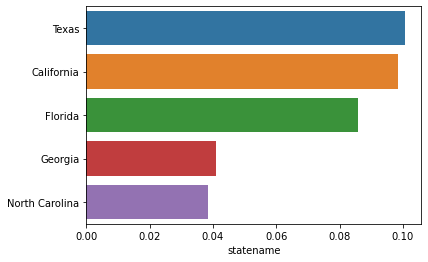

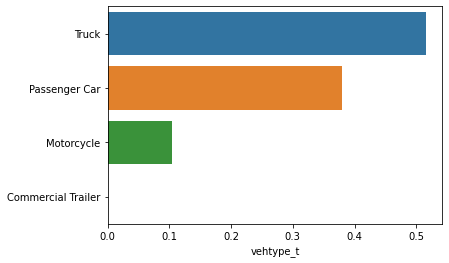

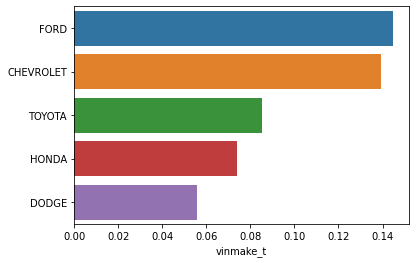

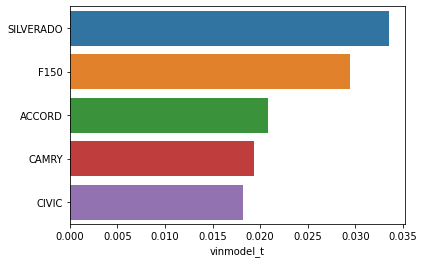

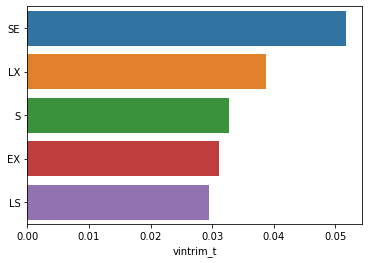

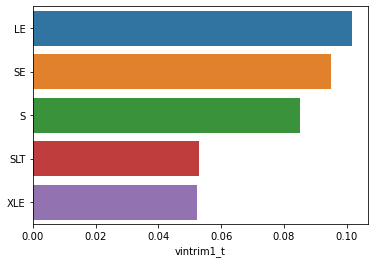

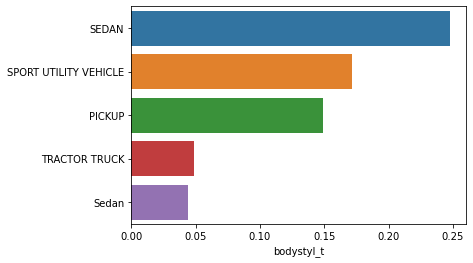

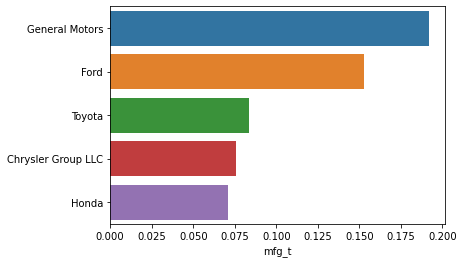

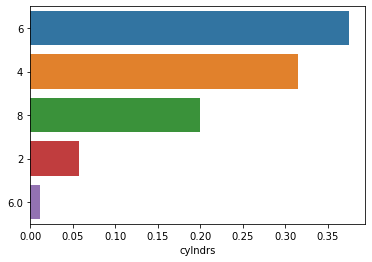

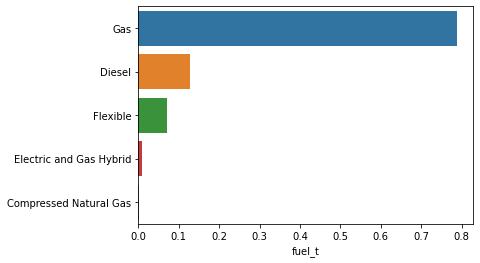

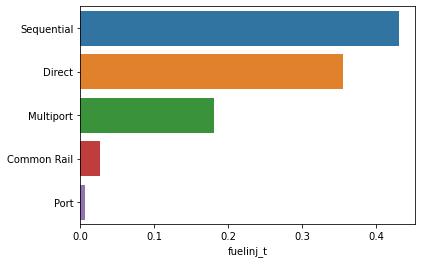

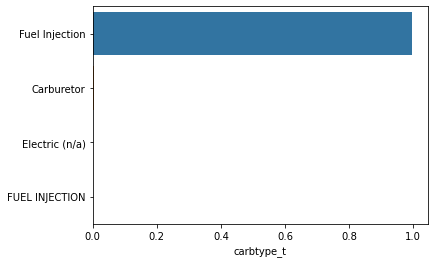

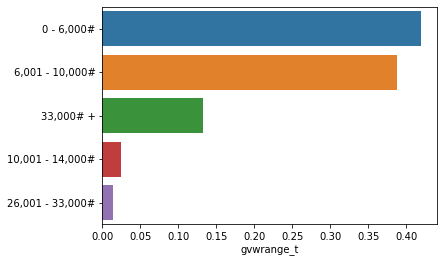

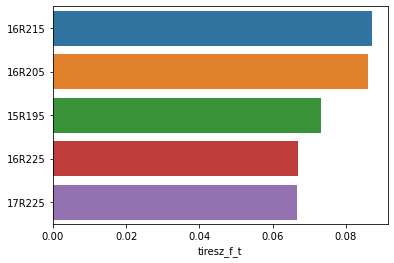

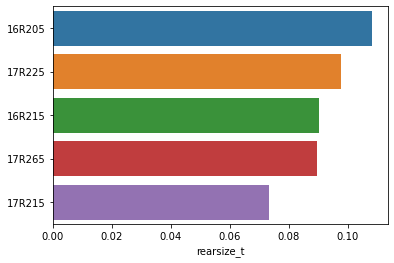

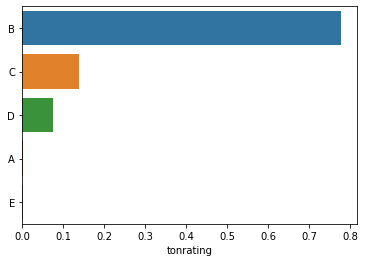

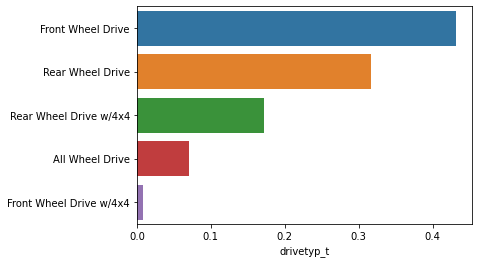

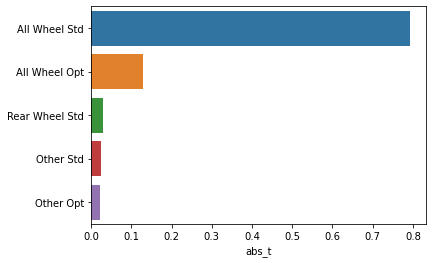

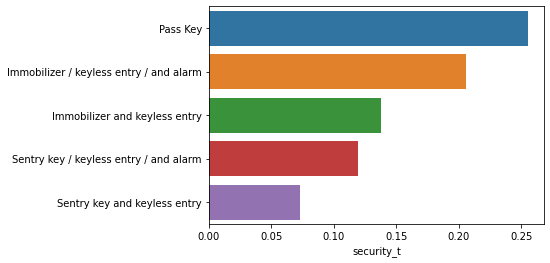

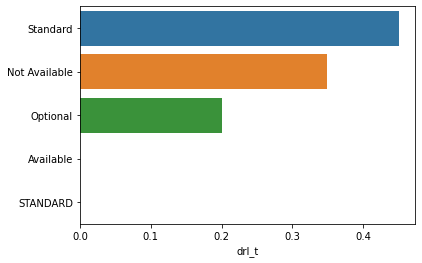

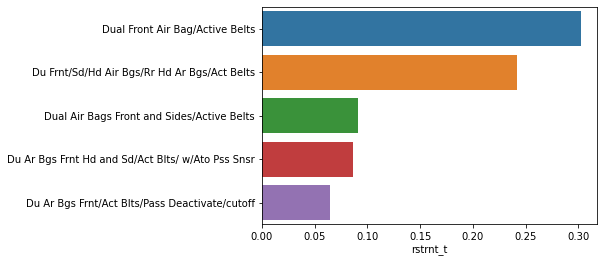

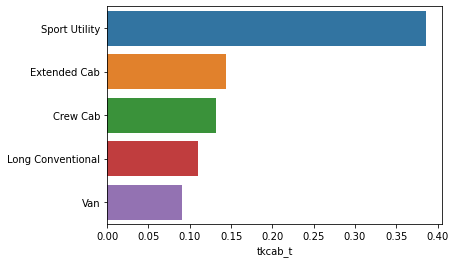

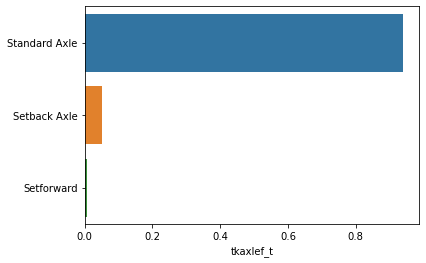

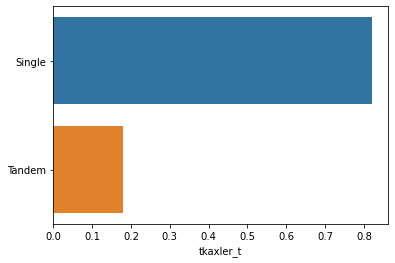

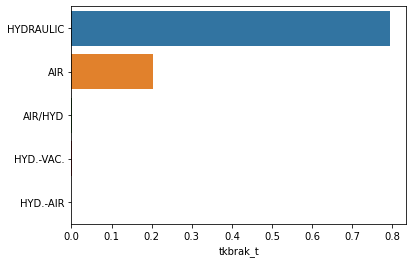

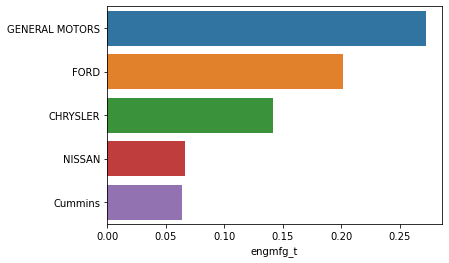

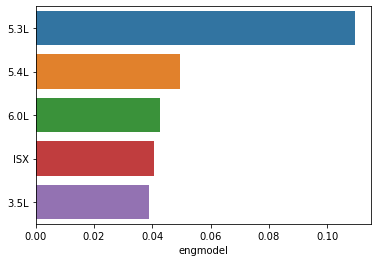

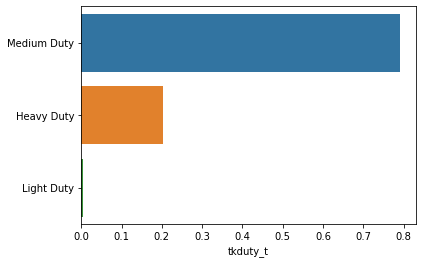

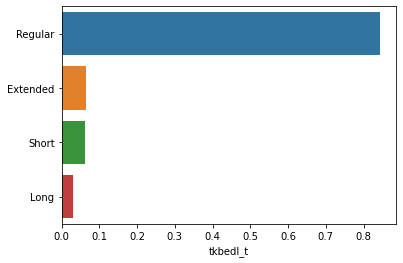

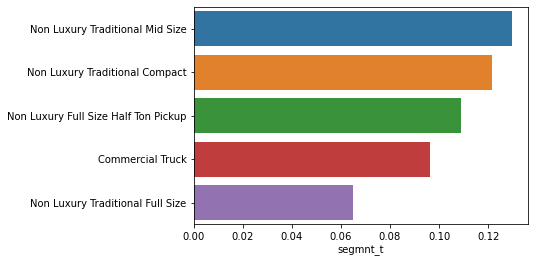

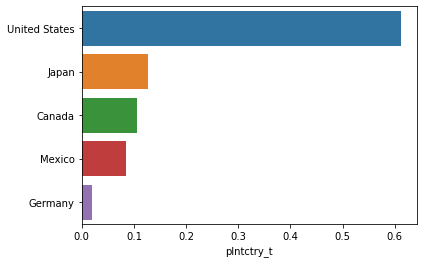

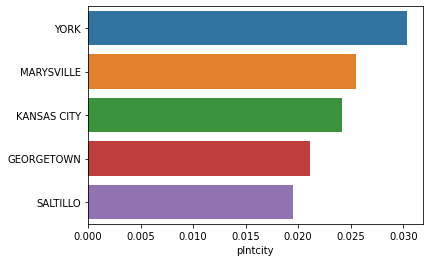

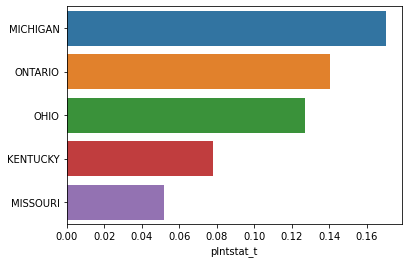

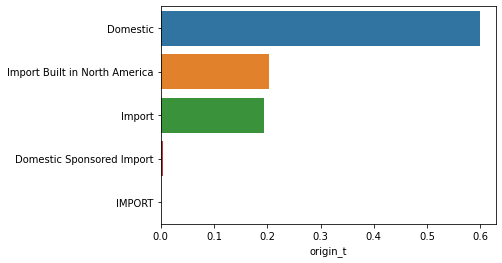

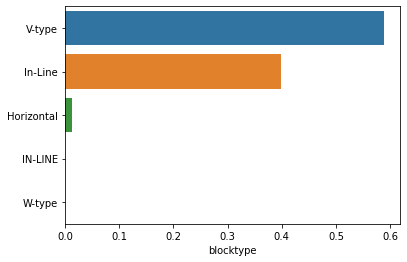

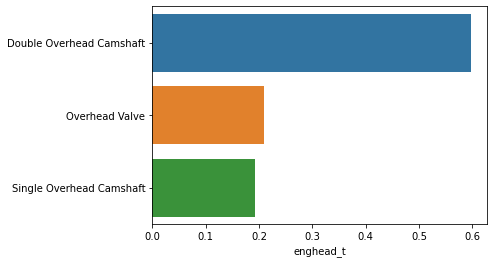

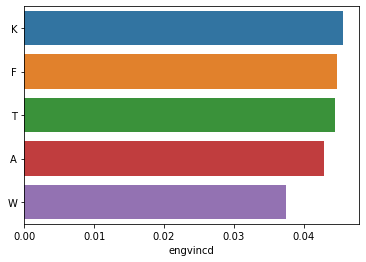

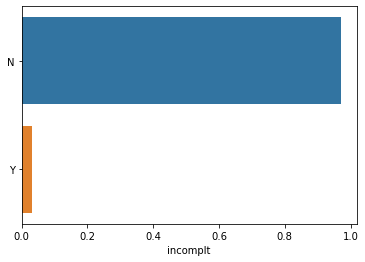

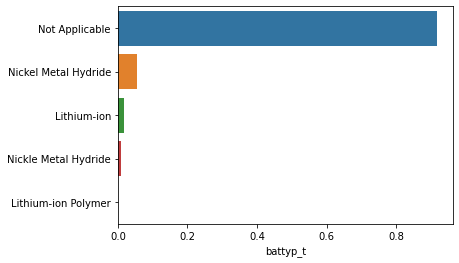

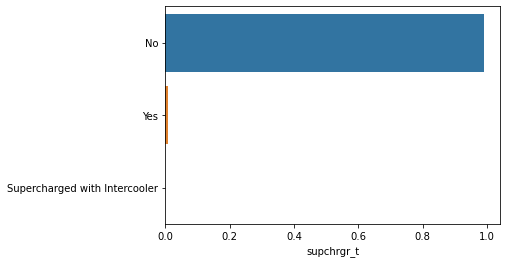

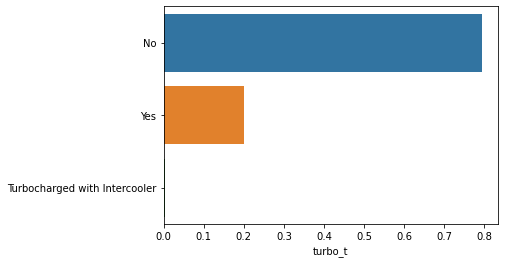

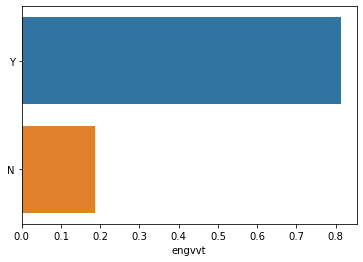

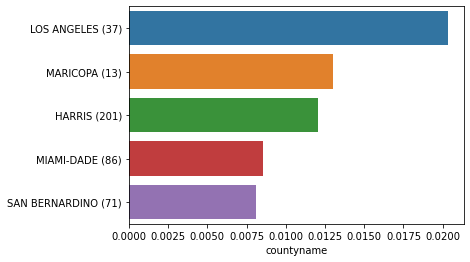

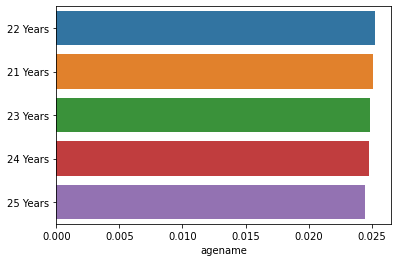

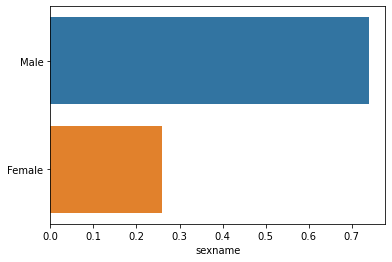

In [11]:
# Printing bar plots of categorical features' 5 greatest value counts...
for feature in data.dtypes[categorical].index:
    value_percentages = data[feature].value_counts(normalize=True, sort=True)[0:5]
    sns.barplot(x=value_percentages, y=value_percentages.index, orient='h', order=value_percentages.index)
    plt.show()

<AxesSubplot:>

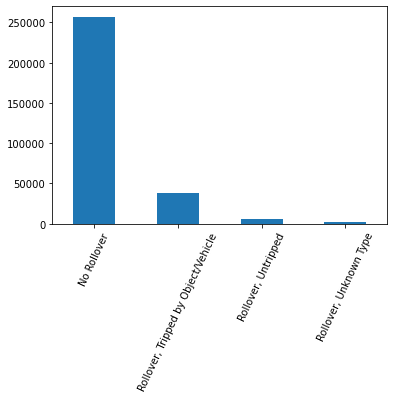

In [12]:
data[target_name].value_counts().plot.bar(rot=65)

<ipython-input-13-95242ea6274d>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data[numeric].hist(ax = ax)


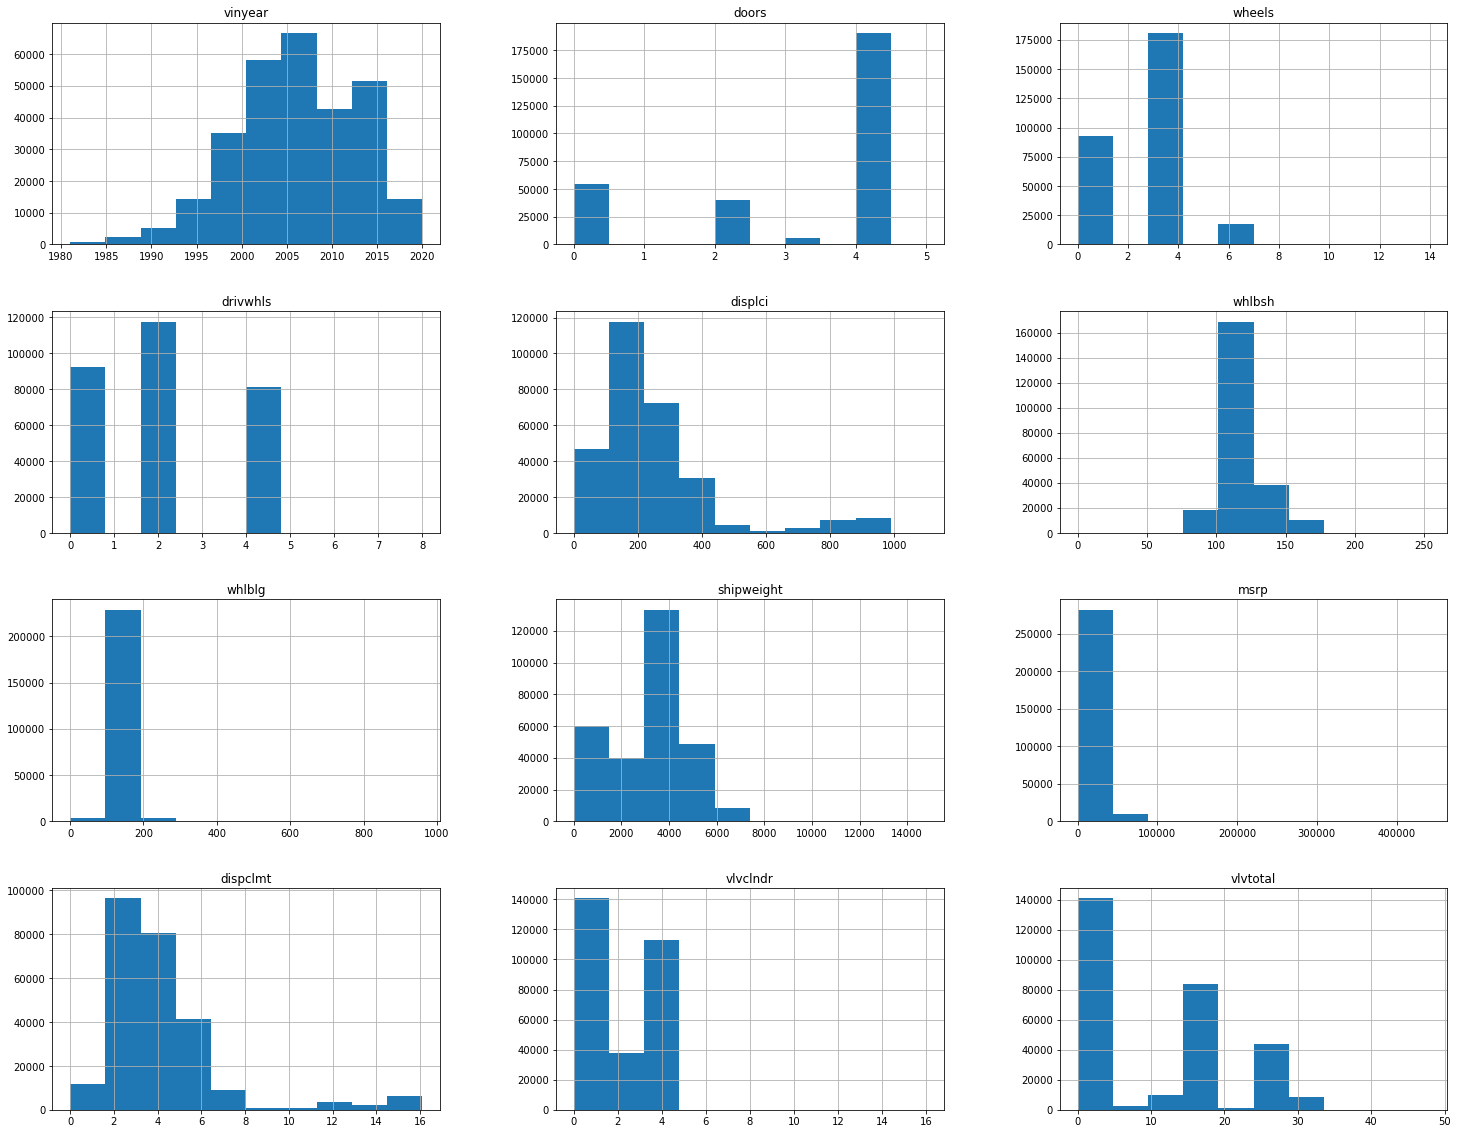

In [13]:
# Printing the histograms of numeric values
fig = plt.figure(figsize = (25,20))
ax = fig.gca()
data[numeric].hist(ax = ax)
plt.show()

In [14]:
for feature in numeric:
    print(data[feature].value_counts(dropna=False), "\n")

2007.0    17595
2006.0    17476
2005.0    17254
2004.0    16068
2003.0    15539
2008.0    14267
2002.0    14111
2013.0    13925
2014.0    13775
2015.0    13310
NaN       12870
2012.0    12619
2001.0    12567
2000.0    11900
2011.0    10788
2016.0    10537
2010.0     9760
2009.0     9539
1999.0     9535
2017.0     7482
1998.0     7436
1997.0     6282
2018.0     4656
1996.0     4484
1995.0     4129
1994.0     3266
1993.0     2341
2019.0     2058
1992.0     1696
1991.0     1356
1990.0     1124
1989.0      948
1988.0      793
1987.0      576
1986.0      537
1985.0      415
1984.0      322
2020.0      238
1983.0      220
1982.0      177
1981.0      155
Name: vinyear, dtype: int64 

4.0    190301
0.0     54447
2.0     40288
NaN     12870
3.0      5896
5.0       324
Name: doors, dtype: int64 

4.0     180695
0.0      92509
6.0      17917
NaN      12870
8.0         96
10.0        25
12.0         7
2.0          5
14.0         2
Name: wheels, dtype: int64 

2.0    117512
0.0     92509
4.0     81

### 2.4 Statistical Tables

In [15]:
# Statistical table of data
data[numeric].describe().round(2)

,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
count,291256.00,291256.00,291256.00,291256.00,291256.00,235872.00,235871.00,291256.00,291256.00,253168.00,291256.00,291256.00
mean,2006.25,2.96,2.85,1.92,236.79,116.12,119.94,3111.39,21665.61,4.12,1.82,9.76
std,6.85,1.57,2.01,1.54,191.39,15.89,26.04,1710.26,12426.79,2.70,1.86,10.16
min,1981.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2002.00,2.00,0.00,0.00,132.00,105.90,105.90,2564.00,15095.00,2.40,0.00,0.00
50%,2006.00,4.00,4.00,2.00,207.00,110.50,110.50,3342.00,21500.00,3.50,2.00,12.00
75%,2012.00,4.00,4.00,4.00,293.00,120.50,123.90,4160.00,28090.00,5.00,4.00,16.00
max,2020.00,5.00,14.00,8.00,1099.00,254.00,960.00,14795.00,441600.00,16.10,16.00,48.00


#### Changing 0's to NaN's

In [16]:
# 0 values on the following columns will be replaced with np.NaN
cols_to_nullify = ["wheels", "drivwhls", "displci", "whlbsh", "whlblg", "shipweight", "msrp", "dispclmt", "vlvclndr", "vlvtotal"]
for col in cols_to_nullify:
    data[col].replace(0, np.NaN, inplace=True)

In [17]:
data[numeric].describe().round(2)

,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
count,291256.00,291256.00,198747.00,198747.00,260606.00,235842.00,235841.00,260350.00,264058.00,253161.00,150719.00,150406.0
mean,2006.25,2.96,4.18,2.82,264.63,116.14,119.95,3480.74,23897.17,4.12,3.51,18.9
std,6.85,1.57,0.59,0.98,183.21,15.83,26.00,1409.46,10816.78,2.70,0.86,5.2
min,1981.00,0.00,2.00,2.00,39.00,73.50,73.50,83.00,498.00,0.70,1.00,2.0
25%,2002.00,2.00,4.00,2.00,146.00,105.90,105.90,2905.00,17155.75,2.40,3.00,16.0
50%,2006.00,4.00,4.00,2.00,214.00,110.50,110.50,3457.00,22500.00,3.50,4.00,16.0
75%,2012.00,4.00,4.00,4.00,323.00,120.50,123.90,4310.00,28995.00,5.00,4.00,24.0
max,2020.00,5.00,14.00,8.00,1099.00,254.00,960.00,14795.00,441600.00,16.10,16.00,48.0


In [18]:
# Null value percentages of numerical features
percent_missing = data[numeric].isnull().sum() * 100 / len(data[numeric])
missing_value_df_num = pd.DataFrame({'column_name': data[numeric].columns,
                                 'percent_missing': percent_missing})

missing_value_df_num.sort_values("percent_missing", ascending=False, inplace=True)
missing_value_df_num.reset_index(inplace=True, drop=True)
missing_value_df_num

,column_name,percent_missing
0,vlvtotal,50.544840
1,vlvclndr,50.441922
2,wheels,34.649783
3,drivwhls,34.649783
4,whlblg,22.452865
5,whlbsh,22.452536
6,dispclmt,16.757857
7,shipweight,14.394034
8,displci,14.309858
9,msrp,13.174803


In [19]:
for feature in numeric:
    print("\n", data[feature].value_counts(dropna=False), "\n")


 2007.0    17595
2006.0    17476
2005.0    17254
2004.0    16068
2003.0    15539
2008.0    14267
2002.0    14111
2013.0    13925
2014.0    13775
2015.0    13310
NaN       12870
2012.0    12619
2001.0    12567
2000.0    11900
2011.0    10788
2016.0    10537
2010.0     9760
2009.0     9539
1999.0     9535
2017.0     7482
1998.0     7436
1997.0     6282
2018.0     4656
1996.0     4484
1995.0     4129
1994.0     3266
1993.0     2341
2019.0     2058
1992.0     1696
1991.0     1356
1990.0     1124
1989.0      948
1988.0      793
1987.0      576
1986.0      537
1985.0      415
1984.0      322
2020.0      238
1983.0      220
1982.0      177
1981.0      155
Name: vinyear, dtype: int64 


 4.0    190301
0.0     54447
2.0     40288
NaN     12870
3.0      5896
5.0       324
Name: doors, dtype: int64 


 4.0     180695
NaN     105379
6.0      17917
8.0         96
10.0        25
12.0         7
2.0          5
14.0         2
Name: wheels, dtype: int64 


 2.0    117512
NaN    105379
4.0     81179
6.0

#  Part-3: Data Cleaning and Feature Engineering

### 3.1. Handling with Missing Values: Dropping and/or Imputation
> You may drop some rows and columns.<br>
> Imputation with statistical values (mean, median, mode)<br>
> Imputation with a keyword like missing, unknown, etc.<br>

In [20]:
# Create a copy dataframe for transformations
clean_data = data.copy()

In [21]:
# Imputation of null values (numeric)
clean_data['vinyear'].fillna(clean_data['vinyear'].value_counts().idxmax(), inplace=True)
clean_data['doors'].fillna(clean_data['doors'].value_counts().idxmax(), inplace=True)
clean_data['wheels'].fillna(clean_data['wheels'].value_counts().idxmax(), inplace=True)
clean_data['drivwhls'].fillna(clean_data['drivwhls'].value_counts().idxmax(), inplace=True)
clean_data['displci'].fillna(clean_data['displci'].mean(), inplace=True)
clean_data['whlbsh'].fillna(clean_data['whlbsh'].mean(), inplace=True)
clean_data['whlblg'].fillna(clean_data['whlblg'].mean(), inplace=True)
clean_data['shipweight'].fillna(clean_data['shipweight'].mean(), inplace=True)
clean_data['msrp'].fillna(clean_data['msrp'].mean(), inplace=True)
clean_data['dispclmt'].fillna(clean_data['dispclmt'].mean(), inplace=True)
clean_data['vlvclndr'].fillna(clean_data['vlvclndr'].value_counts().idxmax(), inplace=True)
clean_data['vlvtotal'].fillna(clean_data['vlvtotal'].value_counts().idxmax(), inplace=True)
clean_data['displci'].fillna(clean_data['displci'].mean(), inplace=True)

In [22]:
# Checking for nulls
clean_data[numeric].isnull().sum().sum()

0

In [23]:
# Imputation of null values (categorical)
for feature in categorical:
    clean_data[feature].fillna(clean_data[feature].value_counts().idxmax(), inplace=True)

In [24]:
# Checking for nulls
clean_data[categorical].isnull().sum().sum()

0

In [25]:
# Printing value counts for every categorical feature
for feature in categorical:
    print("\n", clean_data[feature].value_counts(dropna=False), "\n")


 Texas                   30626
California              29936
Florida                 26104
Georgia                 12434
North Carolina          11687
Pennsylvania             9993
Ohio                     9561
Tennessee                8689
Illinois                 8686
Michigan                 8605
New York                 8211
South Carolina           8105
Arizona                  7677
Alabama                  7509
Missouri                 7436
Indiana                  7218
Virginia                 6458
Kentucky                 6296
Louisiana                6181
Oklahoma                 5509
Mississippi              5211
Colorado                 5049
New Jersey               4771
Wisconsin                4707
Washington               4508
Maryland                 4426
Arkansas                 4355
Oregon                   3649
Minnesota                3270
Kansas                   3270
New Mexico               2972
Massachusetts            2810
Iowa                     2778
Nevada  


 5.3L         219308
5.4L           4718
6.0L           4066
ISX            3867
3.5L           3712
              ...  
EM5-300           1
OM471             1
E7                1
TD122             1
4B SERIES         1
Name: engmodel, Length: 237, dtype: int64 


 Medium Duty    284450
Heavy Duty      19181
Light Duty        495
Name: tkduty_t, dtype: int64 


 Regular     293514
Extended      4346
Short         4239
Long          2027
Name: tkbedl_t, dtype: int64 


 Non Luxury Traditional Mid Size              77017
Non Luxury Traditional Compact               31741
Non Luxury Full Size Half Ton Pickup         28446
Commercial Truck                             25171
Non Luxury Traditional Full Size             16941
Non Luxury Mid Size SUV                      16151
Non Luxury Compact CUV                       15667
Non Luxury Full Size 3qtr to 1 Ton Pickup    13044
Non Luxury Mid Size Pickup                   11403
Non Luxury Full Size SUV                      8687
Non Luxury Mid

### 3.2. Reducing cardinality of categorical features 
> Some categorical features have a cardinality which will cause to have lots of dummy variables. <br>
> Therefore, it is certainly needed to do some operations on that features. You may even consider dropping some of them. <br>
> Be aware of some risk of information loss caused by operations done in this part.<br>
> **Hint**: There are 37 different values for *bodystyl_t* feature which means vehicle body type. You can map the values into some higher level categories like [TRUCK, VAN, BUS, SPORT, STANDARD, OTHER, ...]. <br>
> You can also utilize [FARS User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813023) for this step.

In [26]:
# Printing unique value counts for every categorical column
categorical_uv = []
for feature in categorical:
    categorical_uv.append({"feature": feature, "unique_value_count": pd.unique(clean_data[feature].values).shape[0]})
categorical_uv = sorted(categorical_uv, key=lambda d: d['unique_value_count'], reverse=True) 
for dict_ in categorical_uv:
    print("{0}: {1}".format(dict_["feature"], dict_["unique_value_count"]))

countyname: 2979
engvincd: 2504
vintrim_t: 2124
vinmodel_t: 2110
plntcity: 533
vintrim1_t: 360
engmodel: 237
vinmake_t: 167
agename: 98
tiresz_f_t: 91
mfg_t: 82
bodystyl_t: 79
rearsize_t: 71
plntstat_t: 56
statename: 52
engmfg_t: 34
segmnt_t: 34
plntctry_t: 34
rstrnt_t: 24
tonrating: 20
cylndrs: 19
security_t: 15
tkcab_t: 15
fuel_t: 11
gvwrange_t: 8
abs_t: 7
fuelinj_t: 6
drivetyp_t: 6
blocktype: 6
battyp_t: 6
drl_t: 5
tkbrak_t: 5
origin_t: 5
vehtype_t: 4
carbtype_t: 4
tkbedl_t: 4
tkaxlef_t: 3
tkduty_t: 3
enghead_t: 3
supchrgr_t: 3
turbo_t: 3
tkaxler_t: 2
incomplt: 2
engvvt: 2
sexname: 2


In [27]:
# Dropping 7 different features
cat_col_rem = ["countyname", "engvincd", "vintrim_t", "vinmodel_t", "plntcity", "vintrim1_t", "engmodel"]
drop_useless_columns(clean_data, cat_col_rem)
categorical = [col for col in categorical if col not in cat_col_rem]
print(categorical)

Shape is dropped from (304126, 58) to (304126, 51) 

['statename', 'vehtype_t', 'vinmake_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plntctry_t', 'plntstat_t', 'origin_t', 'blocktype', 'enghead_t', 'incomplt', 'battyp_t', 'supchrgr_t', 'turbo_t', 'engvvt', 'agename', 'sexname']


In [28]:
print(len(categorical))

38


In [29]:
# Printing unique value counts for every categorical column
categorical_uv = []
for feature in categorical:
    categorical_uv.append({"feature": feature, "unique_value_count": pd.unique(clean_data[feature].values).shape[0]})
categorical_uv = sorted(categorical_uv, key=lambda d: d['unique_value_count'], reverse=True) 
for dict_ in categorical_uv:
    print("{0}: {1}".format(dict_["feature"], dict_["unique_value_count"]))

vinmake_t: 167
agename: 98
tiresz_f_t: 91
mfg_t: 82
bodystyl_t: 79
rearsize_t: 71
plntstat_t: 56
statename: 52
engmfg_t: 34
segmnt_t: 34
plntctry_t: 34
rstrnt_t: 24
tonrating: 20
cylndrs: 19
security_t: 15
tkcab_t: 15
fuel_t: 11
gvwrange_t: 8
abs_t: 7
fuelinj_t: 6
drivetyp_t: 6
blocktype: 6
battyp_t: 6
drl_t: 5
tkbrak_t: 5
origin_t: 5
vehtype_t: 4
carbtype_t: 4
tkbedl_t: 4
tkaxlef_t: 3
tkduty_t: 3
enghead_t: 3
supchrgr_t: 3
turbo_t: 3
tkaxler_t: 2
incomplt: 2
engvvt: 2
sexname: 2


In [30]:
# Printing column names that has greater than 8 unique value counts
categorical_uv_gt_8 = []
for dict_ in categorical_uv:
    if dict_["unique_value_count"] > 8:
        categorical_uv_gt_8.append(dict_["feature"]) 
print(categorical_uv_gt_8)

['vinmake_t', 'agename', 'tiresz_f_t', 'mfg_t', 'bodystyl_t', 'rearsize_t', 'plntstat_t', 'statename', 'engmfg_t', 'segmnt_t', 'plntctry_t', 'rstrnt_t', 'tonrating', 'cylndrs', 'security_t', 'tkcab_t', 'fuel_t']


In [31]:
# Printing value counts of columns that has greater than 8 unique value counts
for feature in categorical_uv_gt_8:
    print("\n", clean_data[feature].value_counts(dropna=False).head(15), "\n")


 FORD               55020
CHEVROLET          40521
TOYOTA             24781
HONDA              21487
DODGE              16269
NISSAN             14584
HARLEY-DAVIDSON    11139
GMC                 8901
JEEP                7698
FREIGHTLINER        7232
HYUNDAI             6551
CHRYSLER            5318
KIA                 5042
SUZUKI              4674
BUICK               4655
Name: vinmake_t, dtype: int64 


 22 Years    14108
21 Years     7472
23 Years     7403
24 Years     7369
25 Years     7282
26 Years     6954
27 Years     6898
28 Years     6603
20 Years     6555
19 Years     6466
29 Years     6427
30 Years     6080
31 Years     5887
18 Years     5764
32 Years     5672
Name: agename, dtype: int64 


 16R215    138716
16R205     15576
15R195     13273
16R225     12123
17R225     12065
15R205     11958
17R265      9487
17R215      9287
17R245      6790
16R235      6271
17R235      6200
16R245      5152
18R235      5008
15R215      4920
14R185      4919
Name: tiresz_f_t, dtype: int64 


In [32]:
def other_segmentation_strategy(col, lt):
    filter_ = clean_data[col].value_counts(dropna=False)[clean_data[col].value_counts(dropna=False) < lt].reset_index()["index"].tolist()
    for val in filter_:
        clean_data[col] = clean_data[col].replace({val: "OTHER"})

In [33]:
# vinmake_t, mfg_t, plntstat_t, engmfg_t, plntctry_t
other_segmentation_strategy("vinmake_t", 5042)
other_segmentation_strategy("mfg_t", 8102)
other_segmentation_strategy("plntstat_t", 6820)
other_segmentation_strategy("statename", 8105)
other_segmentation_strategy("engmfg_t", 5559)
other_segmentation_strategy("plntctry_t", 24468)

In [34]:
def divide_groups_of(feature, num):
    groups = []
    for index in clean_data[feature].index:
        value = clean_data[feature].loc[index]
        if value[0:num] not in groups:
            groups.append(value[0:num])
    return groups

In [35]:
def clean(feature, list_):
    for item in list_:
        clean_data[feature].replace([value for value in pd.unique(clean_data[feature].values) if value.startswith(item)], item, inplace=True)

In [36]:
# tiresz_f_t
clean("tiresz_f_t", divide_groups_of("tiresz_f_t", 2))
clean_data["tiresz_f_t"].value_counts(dropna=False).head(20)

16    182884
17     46265
15     40561
18     16027
14     11093
19      3238
20      2422
13      1400
22       168
12        39
21        28
90         1
Name: tiresz_f_t, dtype: int64

In [37]:
# rearsize_t
clean("rearsize_t", divide_groups_of("rearsize_t", 2))
clean_data["rearsize_t"].value_counts(dropna=False).head(20)

16    246877
17     30607
18     12545
15      7852
19      2992
20      2297
14       764
22       168
21        24
Name: rearsize_t, dtype: int64

In [38]:
# segmnt_t
clean_data["segmnt_t"].replace([value for value in pd.unique(clean_data["segmnt_t"].values) if value.startswith('N')], "Non Luxury", inplace=True)
clean_data["segmnt_t"].replace([value for value in pd.unique(clean_data["segmnt_t"].values) if value.startswith('L')], "Luxury", inplace=True)
clean_data["segmnt_t"].value_counts(dropna=False)

Non Luxury          259525
Commercial Truck     25171
Luxury               19430
Name: segmnt_t, dtype: int64

In [39]:
# cylndrs
clean_data.cylndrs.replace(['1', '1.0'], '1', inplace=True)
clean_data.cylndrs.replace(['2', '2.0'], '2', inplace=True)
clean_data.cylndrs.replace(['3', '3.0'], '3', inplace=True)
clean_data.cylndrs.replace(['4', '4.0'], '4', inplace=True)
clean_data.cylndrs.replace(['5', '5.0'], '5', inplace=True)
clean_data.cylndrs.replace(['6', '6.0'], '6', inplace=True)
clean_data.cylndrs.replace(['8', '8.0'], '8', inplace=True)
clean_data.cylndrs.replace(['10', '10.0'], '10', inplace=True)
clean_data["cylndrs"].value_counts(dropna=False).head(20)

6     125834
4      94664
8      60067
2      17414
1       2598
5       1907
10       934
3        618
R         60
12        23
0          7
Name: cylndrs, dtype: int64

In [40]:
# agename
clean_data.agename.replace([value for value in pd.unique(clean_data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(0,20)], '0-20 Years', inplace=True)
clean_data.agename.replace([value for value in pd.unique(clean_data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(20,40)], '20-40 Years', inplace=True)
clean_data.agename.replace([value for value in pd.unique(clean_data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(40,60)], '40-60 Years', inplace=True)
clean_data.agename.replace([value for value in pd.unique(clean_data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(60,80)], '60-80 Years', inplace=True)
clean_data.agename.replace([value for value in pd.unique(clean_data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(80,100)], '80-104 Years', inplace=True)
clean_data["agename"].value_counts(dropna=False)

20-40 Years     130747
40-60 Years      93297
60-80 Years      50201
0-20 Years       19340
80-104 Years     10535
100 Years            4
101 Years            1
103 Years            1
Name: agename, dtype: int64

In [41]:
# bodystyl_t
clean_data.bodystyl_t.replace(['Van Passenger', 'Van Cargo', 'Step Van', 'Van', 'Cutaway', 'VAN CARGO', 'VAN PASSENGER', 'STEP VAN', 'VAN CAMPER', 'CUTAWAY'], 'VAN', inplace=True)
clean_data.bodystyl_t.replace(['Bus Non School', 'Bus School', 'BUS SCHOOL', 'BUS NON SCHOOL'], 'BUS', inplace=True)
clean_data.bodystyl_t.replace(['Pickup', 'Tractor Truck', 'Straight Truck', 'Sport Utility Truck', 'Incomplete Pickup', 'Motor Home', 'PICKUP', 'STRAIGHT TRUCK', 'TRACTOR TRUCK', 'SPORT UTILITY TRUCK', 'INCOMPLETE PICKUP', 'MOTOR HOME', 'FIRE TRUCK', 'COMMERCIAL CHASSIS', 'FLATBED', 'GRAIN', 'LOGGING'], 'TRUCK', inplace=True)
clean_data.bodystyl_t.replace(['Sport Utility Vehicle', 'Sport', 'Competition', 'Touring', 'TOURING', 'SPORT UTILITY VEHICLE', 'SPORT', 'COMPETITION'], 'SPORT', inplace=True)
clean_data.bodystyl_t.replace(['Sedan', 'Hatchback', 'Coupe', 'Convertible', 'Traditional', 'Wagon', 'Limousine', 'SEDAN', 'HATCHBACK', 'CONVERTIBLE', 'WAGON', 'COUPE', 'TRADITIONAL', 'LIMOUSINE', 'HEARSE'], 'STANDARD', inplace=True)
clean_data.bodystyl_t.replace(['Cruiser', 'CRUISER'], 'CRUISER', inplace=True)
clean_data["bodystyl_t"].value_counts(dropna=False)

STANDARD                      124520
TRUCK                          74832
SPORT                          73127
VAN                            14181
CRUISER                        11086
CAB CHASSIS                     1719
BUS                             1163
ATV                             1012
SCOOTER                          528
ENDURO                           435
SIDE BY SIDE                     379
Cab Chassis                      314
GLIDERS                          239
DIRT BIKE                        154
INCOMPLETE (STRIP CHASSIS)       125
Scooter                          111
Enduro                            82
Gliders                           30
CEMENT MIXER                      21
Incomplete (Strip Chassis)        20
Dirt Bike                         18
GARBAGE/REFUSE                    15
Garbage/Refuse                     5
Fire Truck                         4
TANK                               2
Mini Bike                          2
Cement Mixer                       1
D

In [42]:
# vehtype_t, fuel_t, carbtype_t, turbo_t, drivetyp_t, abs_t, drl_t, supchrgr_t, origin_t
clean_data.vehtype_t.replace(['Truck', 'Commercial Trailer'], 'Truck', inplace=True)
clean_data.fuel_t.replace(['GAS', 'Gas', 'Compressed Natural Gas'], 'Gas', inplace=True)
clean_data.fuel_t.replace(['Electric and Gas Hybrid', 'Electric and Diesel Hybrid'], 'Hybrid', inplace=True)
clean_data.carbtype_t.replace(['Fuel Injection', 'FUEL INJECTION'], 'Fuel Injection', inplace=True)
clean_data.turbo_t.replace(['Yes', 'Turbocharged with Intercooler'], 'Yes', inplace=True)
clean_data.drivetyp_t.replace(['Rear Wheel Drive', 'Rear Wheel Drive w/4x4'], 'Rear Wheel Drive', inplace=True)
clean_data.drivetyp_t.replace(['Front Wheel Drive', 'Front Wheel Drive w/4x4', 'FRONT WHEEL DRIVE'], 'Front Wheel Drive', inplace=True)
clean_data.abs_t.replace(['All Wheel Std', 'ALL WHEEL STD'], 'All Wheel Std', inplace=True)
clean_data.drl_t.replace(['Standard', 'STANDARD'], 'Standard', inplace=True)
clean_data.supchrgr_t.replace(['Yes', 'Supercharged with Intercooler'], 'Yes', inplace=True)
clean_data.origin_t.replace(['Import', 'Domestic Sponsored Import', 'Import Built in North America'], 'Import', inplace=True)


In [43]:
# battyp_t, tkbrak_t, blocktype
clean_data.battyp_t.replace(['Lithium-ion', 'Lithium-ion Polymer'], 'Lithium Ion', inplace=True)
clean_data.tkbrak_t.replace(['AIR/HYD', 'HYD.-VAC.', 'HYD.-AIR'], 'HYDRAULIC', inplace=True)
clean_data.blocktype.replace(['IN-LINE'], 'In-Line', inplace=True)
clean_data.blocktype.replace(['W-type', 'Rotary'], 'V-type', inplace=True)

In [44]:
# rollovername
clean_data.rollovername.replace(['Rollover, Tripped by Object/Vehicle', 'Rollover, Untripped', 'Rollover, Unknown Type'], 'Rollover', inplace=True)
clean_data["rollovername"].value_counts(dropna=True)

No Rollover    257110
Rollover        47016
Name: rollovername, dtype: int64

In [45]:
# Unique value counts after reducing cardinality
categorical_uv = []
for feature in categorical:
    categorical_uv.append({"feature": feature, "unique_value_count": pd.unique(clean_data[feature].values).shape[0]})
categorical_uv = sorted(categorical_uv, key=lambda d: d['unique_value_count'], reverse=True) 
for dict_ in categorical_uv:
    print("{0}: {1}".format(dict_["feature"], dict_["unique_value_count"]))

bodystyl_t: 28
rstrnt_t: 24
tonrating: 20
security_t: 15
tkcab_t: 15
vinmake_t: 14
statename: 13
tiresz_f_t: 12
cylndrs: 11
plntstat_t: 11
mfg_t: 10
rearsize_t: 9
fuel_t: 8
gvwrange_t: 8
engmfg_t: 8
agename: 8
fuelinj_t: 6
abs_t: 6
plntctry_t: 5
drl_t: 4
tkbedl_t: 4
battyp_t: 4
vehtype_t: 3
carbtype_t: 3
drivetyp_t: 3
tkaxlef_t: 3
tkduty_t: 3
segmnt_t: 3
origin_t: 3
blocktype: 3
enghead_t: 3
tkaxler_t: 2
tkbrak_t: 2
incomplt: 2
supchrgr_t: 2
turbo_t: 2
engvvt: 2
sexname: 2


### BONUS: 3.3. Identifying and handling with outliers 
(not required, might help for linear and probabilistic models, be aware of the risk of information loss) 

In [ ]:
# YOUR CODE HERE

> You may want to repeat some parts of EDA for the processed data at the end of this part, so, you may review your insights from the data to serve for the feature selection.

#  Part-4: Data Splitting and Transformation
> Firstly, split your data into training and test datasets before the data transformation. <br>
Then, scale numerical features and encode categorical features based on the training dataset.

To split the dataset, which of the following strategies is better?:

(1) Using accidents in 2019 for testing. <br>
(2) Getting random 30% of data for testing.

Which choice you selected will not matter for grading, but, how you choose it matters for the learning task. Think about which testing approach is more reasonable/meaningful regarding to create a business value. 

**Note:** If you have included year as a feature and you select (1), you should scale it properly for testing dataset. <br>

### 4.1 Splitting the Data

In [46]:
features = categorical + numeric
x_ = clean_data[features]
x_.head()

,statename,vehtype_t,vinmake_t,bodystyl_t,mfg_t,cylndrs,fuel_t,fuelinj_t,carbtype_t,gvwrange_t,tiresz_f_t,rearsize_t,tonrating,drivetyp_t,abs_t,security_t,drl_t,rstrnt_t,tkcab_t,tkaxlef_t,tkaxler_t,tkbrak_t,engmfg_t,tkduty_t,tkbedl_t,segmnt_t,plntctry_t,plntstat_t,origin_t,blocktype,enghead_t,incomplt,battyp_t,supchrgr_t,turbo_t,engvvt,agename,sexname,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
0,OTHER,Passenger Car,TOYOTA,STANDARD,OTHER,4,Gas,Sequential,Fuel Injection,"0 - 6,000#",15,15,B,Front Wheel Drive,All Wheel Std,Immobilizer and keyless entry,Standard,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,Canada,ONTARIO,Import,In-Line,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Male,2011.0,4.0,4.0,2.0,110.0,102.4,102.4,2734.0,15600.0,1.8,4.0,16.0
1,OTHER,Truck,DODGE,TRUCK,OTHER,8,Gas,Sequential,Fuel Injection,"6,001 - 10,000#",16,16,C,Rear Wheel Drive,Other Std,Pass Key,Not Available,Driver Front Air Bag/Passenger Active Belts,Extended Cab,Standard Axle,Single,HYDRAULIC,CHRYSLER,Medium Duty,Regular,Non Luxury,Mexico,MICHIGAN,Domestic,V-type,Overhead Valve,N,Not Applicable,No,No,Y,40-60 Years,Male,1997.0,2.0,4.0,2.0,360.0,138.7,154.7,4787.0,20775.0,5.9,2.0,16.0
2,OTHER,Passenger Car,CHEVROLET,STANDARD,GENERAL MOTORS,6,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,B,Front Wheel Drive,All Wheel Std,Pass Key,Standard,Dual Air Bags Front and Sides/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,United States,OTHER,Domestic,V-type,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Male,2004.0,4.0,4.0,2.0,214.0,106.3,106.3,3315.0,23495.0,3.5,4.0,16.0
3,OTHER,Passenger Car,TOYOTA,STANDARD,OTHER,6,Gas,Sequential,Fuel Injection,"0 - 6,000#",15,16,B,Front Wheel Drive,All Wheel Opt,Pass Key,Not Available,Dual Front Air Bag/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,United States,KENTUCKY,Import,V-type,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Female,1997.0,4.0,4.0,2.0,183.0,105.1,105.1,3086.0,19248.0,3.0,4.0,24.0
4,OTHER,Truck,TOYOTA,TRUCK,OTHER,4,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,B,Rear Wheel Drive,All Wheel Opt,Pass Key,Not Available,Du Ar Bgs Frnt/Act Blts/Pass Deactivate/cutoff,Conventional,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,United States,OTHER,Import,In-Line,Double Overhead Camshaft,N,Not Applicable,No,No,Y,80-104 Years,Male,1999.0,2.0,4.0,2.0,149.0,103.3,103.3,2567.0,12698.0,2.4,4.0,16.0


In [47]:
y_ = clean_data[target_name]
y_.head()

0       Rollover
1    No Rollover
2    No Rollover
3    No Rollover
4    No Rollover
Name: rollovername, dtype: object

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.3, random_state=42)

In [49]:
x_train.head()

,statename,vehtype_t,vinmake_t,bodystyl_t,mfg_t,cylndrs,fuel_t,fuelinj_t,carbtype_t,gvwrange_t,tiresz_f_t,rearsize_t,tonrating,drivetyp_t,abs_t,security_t,drl_t,rstrnt_t,tkcab_t,tkaxlef_t,tkaxler_t,tkbrak_t,engmfg_t,tkduty_t,tkbedl_t,segmnt_t,plntctry_t,plntstat_t,origin_t,blocktype,enghead_t,incomplt,battyp_t,supchrgr_t,turbo_t,engvvt,agename,sexname,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
83341,South Carolina,Passenger Car,OTHER,STANDARD,OTHER,4,Gas,Sequential,Fuel Injection,"0 - 6,000#",15,16,B,Front Wheel Drive,All Wheel Opt,Pass Key,Standard,Dual Air Bags Front and Sides/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,OTHER,MICHIGAN,Import,In-Line,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Male,2007.0,4.0,4.0,2.0,122.0,102.400000,102.400000,2700.000000,13999.000000,2.000000,4.0,16.0
138707,Texas,Truck,OTHER,SPORT,OTHER,6,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,A,Rear Wheel Drive,Other Std,Pass Key,Standard,Dual Front Air Bag/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,United States,INDIANA,Import,V-type,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Male,2000.0,4.0,4.0,2.0,195.0,106.400000,106.400000,3848.000000,20985.000000,3.200000,4.0,24.0
172148,OTHER,Passenger Car,OTHER,STANDARD,General Motors,6,Gas,Sequential,Fuel Injection,"0 - 6,000#",15,16,B,Front Wheel Drive,All Wheel Std,Pass Key,Standard,Dual Air Bags Front and Sides/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,United States,MICHIGAN,Domestic,V-type,Overhead Valve,N,Not Applicable,No,No,Y,80-104 Years,Male,2005.0,4.0,4.0,2.0,232.0,112.200000,112.200000,3591.000000,32385.000000,3.800000,4.0,16.0
11954,Georgia,Truck,FORD,TRUCK,FORD,8,Gas,Sequential,Fuel Injection,"6,001 - 10,000#",16,16,B,Rear Wheel Drive,All Wheel Std,Pass Key,Optional,Du Ar Bgs Frnt/Act Blts/Pass Deactivate/cutoff,Extended Cab,Standard Axle,Single,HYDRAULIC,FORD,Medium Duty,Regular,Non Luxury,United States,OTHER,Domestic,V-type,Single Overhead Camshaft,N,Not Applicable,No,No,Y,40-60 Years,Male,2001.0,4.0,4.0,2.0,281.0,138.500000,157.100000,4204.000000,19515.000000,4.600000,2.0,16.0
280873,OTHER,Truck,OTHER,TRUCK,General Motors,6,Diesel,Sequential,Fuel Injection,"33,000# +",16,16,B,Rear Wheel Drive,All Wheel Std,Pass Key,Standard,Dual Front Air Bag/Active Belts,Long Conventional,Standard Axle,Tandem,AIR,OTHER,Heavy Duty,Regular,Commercial Truck,Canada,ONTARIO,Domestic,V-type,Double Overhead Camshaft,Y,Not Applicable,No,No,Y,40-60 Years,Male,2005.0,0.0,6.0,4.0,782.0,116.136106,119.954596,3480.737945,23897.168864,4.117856,4.0,16.0


In [50]:
x_test.head()

,statename,vehtype_t,vinmake_t,bodystyl_t,mfg_t,cylndrs,fuel_t,fuelinj_t,carbtype_t,gvwrange_t,tiresz_f_t,rearsize_t,tonrating,drivetyp_t,abs_t,security_t,drl_t,rstrnt_t,tkcab_t,tkaxlef_t,tkaxler_t,tkbrak_t,engmfg_t,tkduty_t,tkbedl_t,segmnt_t,plntctry_t,plntstat_t,origin_t,blocktype,enghead_t,incomplt,battyp_t,supchrgr_t,turbo_t,engvvt,agename,sexname,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
35578,OTHER,Truck,FORD,SPORT,FORD,6,Gas,Sequential,Fuel Injection,"6,001 - 10,000#",18,18,B,Front Wheel Drive,All Wheel Std,Sentry key / keyless entry / and alarm,Optional,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,FORD,Medium Duty,Regular,Non Luxury,United States,ILLINOIS,Domestic,V-type,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Female,2011.0,4.0,4.0,2.0,214.000000,112.600000,112.600000,4578.0,31190.0,3.500000,4.0,24.0
176433,OTHER,Truck,CHEVROLET,VAN,General Motors,4,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,B,Front Wheel Drive,All Wheel Opt,Immobilizer and keyless entry,Standard,Dual Front Air Bag/Active Belts,Van,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,Mexico,MICHIGAN,Domestic,In-Line,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Female,2006.0,4.0,4.0,2.0,146.000000,103.500000,103.500000,3155.0,16425.0,2.400000,4.0,16.0
50399,California,Passenger Car,TOYOTA,STANDARD,Toyota,4,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,B,Front Wheel Drive,All Wheel Std,Immobilizer and keyless entry,Standard,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,United States,KENTUCKY,Import,In-Line,Double Overhead Camshaft,N,Not Applicable,No,No,Y,40-60 Years,Male,2012.0,4.0,4.0,2.0,152.000000,109.300000,109.300000,3190.0,21955.0,2.500000,4.0,16.0
228921,OTHER,Motorcycle,HONDA,SPORT,Honda,1,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,B,Front Wheel Drive,All Wheel Std,Pass Key,Standard,Dual Front Air Bag/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,Japan,MICHIGAN,Import,V-type,Double Overhead Camshaft,N,Not Applicable,No,No,Y,0-20 Years,Male,2005.0,0.0,4.0,2.0,264.634962,116.136106,119.954596,219.0,6699.0,4.117856,4.0,16.0
276062,OTHER,Truck,CHEVROLET,SPORT,General Motors,6,Gas,Sequential,Fuel Injection,"0 - 6,000#",16,16,B,All Wheel Drive,All Wheel Opt,Keyless entry and alarm,Standard,Dual Front Air Bag/Active Belts,Sport Utility,Standard Axle,Single,HYDRAULIC,GENERAL MOTORS,Medium Duty,Regular,Non Luxury,Canada,ONTARIO,Domestic,V-type,Double Overhead Camshaft,N,Not Applicable,No,No,Y,20-40 Years,Male,2006.0,4.0,4.0,4.0,207.000000,112.500000,112.500000,3777.0,24675.0,3.400000,4.0,16.0


In [51]:
print("x_train shape:", x_train.shape)
print("x_test  shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

x_train shape: (212888, 50)
x_test  shape: (91238, 50)
y_train shape: (212888,)
y_test  shape: (91238,)


### 4.2 Scale Numerical Features

In [52]:
scaler = MinMaxScaler(feature_range=(0,1))

In [53]:
x_train[numeric] = scaler.fit_transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

<ipython-input-53-811eb9ed7585>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[numeric] = scaler.fit_transform(x_train[numeric])
C:\Users\Tuna\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-53-811eb9ed7585>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [54]:
x_train[numeric]

,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
83341,0.666667,0.8,0.166667,0.0,0.064176,0.160111,0.032600,0.182717,0.030607,0.072368,0.200000,0.304348
138707,0.487179,0.8,0.166667,0.0,0.134100,0.182271,0.037112,0.263176,0.046445,0.151316,0.200000,0.478261
172148,0.615385,0.8,0.166667,0.0,0.169540,0.214404,0.043655,0.245164,0.072289,0.190789,0.200000,0.304348
11954,0.512821,0.8,0.166667,0.0,0.216475,0.360111,0.094303,0.288127,0.043112,0.243421,0.066667,0.304348
280873,0.615385,0.0,0.333333,0.5,0.696360,0.236211,0.052402,0.237436,0.053047,0.211701,0.200000,0.304348
...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.666667,0.8,0.166667,0.0,0.200800,0.236211,0.052402,0.237436,0.053047,0.211701,0.200000,0.304348
259178,0.589744,0.8,0.166667,0.5,0.139847,0.253740,0.051664,0.299411,0.062938,0.157895,0.200000,0.478261
131932,0.410256,0.4,0.166667,0.0,0.040230,0.164543,0.033503,0.169470,0.035257,0.046053,0.200000,0.304348
146867,0.512821,0.0,0.166667,0.0,0.367816,0.236211,0.052402,0.237436,0.053047,0.414474,0.200000,0.304348


In [55]:
x_test[numeric]

,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
35578,0.769231,0.8,0.166667,0.0,0.152299,0.216620,0.044106,0.314340,0.069580,0.171053,0.2,0.478261
176433,0.641026,0.8,0.166667,0.0,0.087165,0.166205,0.033841,0.214606,0.036107,0.098684,0.2,0.304348
50399,0.794872,0.8,0.166667,0.0,0.092912,0.198338,0.040384,0.217059,0.048644,0.105263,0.2,0.304348
228921,0.615385,0.0,0.166667,0.0,0.200800,0.236211,0.052402,0.008831,0.014058,0.211701,0.2,0.304348
276062,0.641026,0.8,0.166667,0.5,0.145594,0.216066,0.043993,0.258200,0.054810,0.164474,0.2,0.304348
...,...,...,...,...,...,...,...,...,...,...,...,...
150254,0.794872,0.0,0.166667,0.0,0.200800,0.236211,0.052402,0.036445,0.018118,0.211701,0.2,0.304348
91840,0.461538,0.0,0.166667,0.0,0.200800,0.236211,0.052402,0.019414,0.017005,0.211701,0.2,0.304348
93395,0.641026,0.8,0.166667,0.0,0.064176,0.162881,0.033164,0.184749,0.031630,0.072368,0.2,0.304348
192270,0.589744,0.8,0.166667,0.0,0.192529,0.218837,0.044557,0.303616,0.062337,0.217105,0.2,0.304348


In [56]:
print("x_train shape:", x_train.shape)
print("x_test  shape:", x_test.shape)

x_train shape: (212888, 50)
x_test  shape: (91238, 50)


### 4.3 Encode Categorical Features

In [57]:
encoder=OneHotEncoder(sparse=False, handle_unknown='ignore')

In [58]:
x_train_final = pd.DataFrame(encoder.fit_transform(x_train[categorical]))

In [59]:
x_train_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [60]:
# This is the final version of x_train
x_train_final = pd.DataFrame(np.concatenate((encoder.fit_transform(x_train[categorical]), x_train[numeric]), axis=1))

In [61]:
x_train_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.8,0.166667,0.0,0.064176,0.160111,0.032600,0.182717,0.030607,0.072368,0.200000,0.304348
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.487179,0.8,0.166667,0.0,0.134100,0.182271,0.037112,0.263176,0.046445,0.151316,0.200000,0.478261
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.615385,0.8,0.166667,0.0,0.169540,0.214404,0.043655,0.245164,0.072289,0.190789,0.200000,0.304348
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.512821,0.8,0.166667,0.0,0.216475,0.360111,0.094303,0.288127,0.043112,0.243421,0.066667,0.304348
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.615385,0.0,0.333333,0.5,0.696360,0.236211,0.052402,0.237436,0.053047,0.211701,0.200000,0.304348


In [62]:
# This is the final version of x_test
x_test_final = pd.DataFrame(np.concatenate((encoder.transform(x_test[categorical]), x_test[numeric]), axis=1))

In [63]:
x_test_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.769231,0.8,0.166667,0.0,0.152299,0.216620,0.044106,0.314340,0.069580,0.171053,0.2,0.478261
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.641026,0.8,0.166667,0.0,0.087165,0.166205,0.033841,0.214606,0.036107,0.098684,0.2,0.304348
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.794872,0.8,0.166667,0.0,0.092912,0.198338,0.040384,0.217059,0.048644,0.105263,0.2,0.304348
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.615385,0.0,0.166667,0.0,0.200800,0.236211,0.052402,0.008831,0.014058,0.211701,0.2,0.304348
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.641026,0.8,0.166667,0.5,0.145594,0.216066,0.043993,0.258200,0.054810,0.164474,0.2,0.304348


In [64]:
print("x_train_final shape:", x_train_final.shape)
print("x_test_final  shape:", x_test_final.shape)

x_train_final shape: (212888, 294)
x_test_final  shape: (91238, 294)


In [65]:
# Replacing No Rollover and Rollover values with 0s and 1s
y_train.replace(['No Rollover'], 0, inplace=True)
y_train.replace(['Rollover'], 1, inplace=True)

y_test.replace(['No Rollover'], 0, inplace=True)
y_test.replace(['Rollover'], 1, inplace=True)

In [66]:
y_train

83341     0
138707    0
172148    0
11954     0
280873    1
         ..
119879    0
259178    0
131932    0
146867    0
121958    0
Name: rollovername, Length: 212888, dtype: int64

In [67]:
y_test

35578     0
176433    1
50399     0
228921    0
276062    0
         ..
150254    0
91840     0
93395     0
192270    1
128332    0
Name: rollovername, Length: 91238, dtype: int64

#  Part-5: Feature Selection

> You are required to present **at most 30** useful features at the end of the project.<br>
> It is not required to have 30 features before training. You should eliminate some features before and after the data learning phase to report at the end. <br>
> So, you need to select one or multiple feature subsets to experiment ML models.<br>
> It is worthy to note that you are not encouraged to be minimalistic (like using 5 features) while the selection because it might sacrifice some learning performance. But maybe only 5 features can be useful, it is unknown for now and it will turn out with your selection approach.

You can either select features manually and/or in an automated way.
If you deploy an automated feature selection method, you **must explain how it works** in the report.

Some manual ways: Thresholding correlations, multicollinearity inspection, considering value distributions with respect to the target variable, finding non-informative features, ...

Some automated ways: 
- selecting the best k variables based on a statistical score 
- forward/backward/recursive feature elimination
- identifying important features using a decision-tree based model

In [68]:
select_10 = SelectKBest(score_func=chi2,k=10)
x_train_final_selected_10 = select_10.fit_transform(x_train_final,y_train)
x_test_final_selected_10 = select_10.transform(x_test_final)

In [69]:
print("TRAIN")
print("Shape of 10 col selections:", x_train_final_selected_10.shape)

TRAIN
Shape of 10 col selections: (212888, 10)


In [70]:
print("TEST")
print("Shape of 10 col selections:", x_test_final_selected_10.shape)

TEST
Shape of 10 col selections: (91238, 10)


In [71]:
print("Indexes of columns of 10 col selection:", x_train_final.columns[select_10.get_support()].tolist(), "\n")

Indexes of columns of 10 col selection: [13, 15, 22, 34, 63, 72, 77, 144, 145, 168] 



#  Part-6: Training and Performance Evaluation

> You need to determine a score which is proper for the learning task and the distribution of target variable to benchmark the models. Note that even a model is successful for a target metric, it might performs poorly in terms of other performance scores. So, you should observe multiple metrics. <br>
> **Hint:** Think about which type of error made in predictions is more harmful from a car insurance business perspective: False negative  or false positive predictions? <br>

> According EDA done in the previous parts, you might need to adress any imbalanced dataset problem. (Not expected to use advanced methods or to do an extensive experimentation) <br>
**Hint**: Inspect model parameters which are related to class weightening or loss weightening.

> You have three Naive-Bayes-based model options for benchmarking with other types of models: ```GaussianNB```, ```CategoricalNB```, and ```ComplementNB```.
Read the descriptions provided in Sklearn library or search them on the Internet, and choose one of them regarding which sounds more reasonable considering the dataset characteristics and the learning task.<br>
**BONUS**: Experiment a simple prediction technique ensembling multiple Naive-Bayes models. (not required)

### Creating Models

In [72]:
cnb = ComplementNB()
cnb.fit(x_train_final_selected_10, y_train)

ComplementNB()

In [73]:
lreg = LogisticRegression(random_state=42)
lreg.fit(x_train_final_selected_10, y_train)

LogisticRegression(random_state=42)

In [74]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train_final_selected_10, y_train)

RandomForestClassifier(random_state=42)

In [75]:
svms = SVC()
svms.fit(x_train_final_selected_10, y_train)

SVC()

### Printing the Classification Reports

In [76]:
# Naive Bayes
print(classification_report(y_test, cnb.predict(x_test_final_selected_10)))

              precision    recall  f1-score   support

           0       0.90      0.54      0.67     77111
           1       0.21      0.66      0.31     14127

    accuracy                           0.55     91238
   macro avg       0.55      0.60      0.49     91238
weighted avg       0.79      0.55      0.61     91238



In [77]:
# Logistic Regression
print(classification_report(y_test, lreg.predict(x_test_final_selected_10)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     77111
           1       0.00      0.00      0.00     14127

    accuracy                           0.85     91238
   macro avg       0.42      0.50      0.46     91238
weighted avg       0.71      0.85      0.77     91238



C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
# Random Forest
print(classification_report(y_test, rfc.predict(x_test_final_selected_10)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     77111
           1       0.00      0.00      0.00     14127

    accuracy                           0.85     91238
   macro avg       0.42      0.50      0.46     91238
weighted avg       0.71      0.85      0.77     91238



C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
# Support Vector Machines
print(classification_report(y_test, svms.predict(x_test_final_selected_10)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     77111
           1       0.00      0.00      0.00     14127

    accuracy                           0.85     91238
   macro avg       0.42      0.50      0.46     91238
weighted avg       0.71      0.85      0.77     91238



C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plotting Bar Charts for the Testing Performances

> Plot training and testing performance of all models with a bar chart.

In [80]:
def plot_cr(cr):
    df = pd.DataFrame([['0 (NR)','precision', cr['0']['precision']], ['0 (NR)', 'recall', cr['0']['recall']], ['0 (NR)', 'f1-score', cr['0']['f1-score']], ['1 (R)', 'precision', cr['1']['precision']],
                       ['1 (R)', 'recall', cr['1']['recall']], ['1 (R)', 'f1-score', cr['1']['f1-score']]], columns=['rollovername','column','val'])
    df.pivot("column", "rollovername", "val").plot(kind='bar', rot=0)
    plt.xlabel("")
    plt.show()

In [81]:
cnb_cr = classification_report(y_test, cnb.predict(x_test_final_selected_10), output_dict=True)
lreg_cr = classification_report(y_test, lreg.predict(x_test_final_selected_10), output_dict=True)
rfc_cr = classification_report(y_test, rfc.predict(x_test_final_selected_10), output_dict=True)
svms_cr = classification_report(y_test, svms.predict(x_test_final_selected_10), output_dict=True)

C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tuna\anaconda3\lib\site-packages\sklearn\metrics\

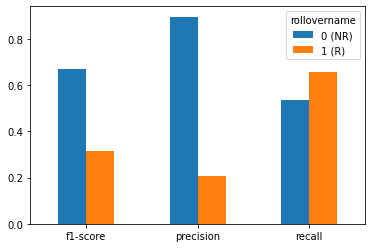

In [82]:
plot_cr(cnb_cr)

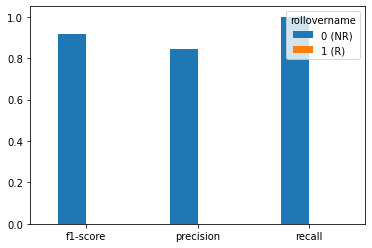

In [83]:
plot_cr(lreg_cr)

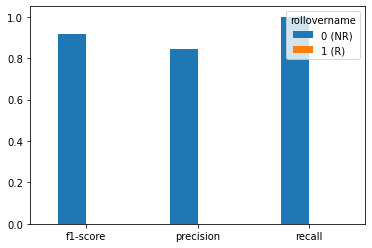

In [84]:
plot_cr(rfc_cr)

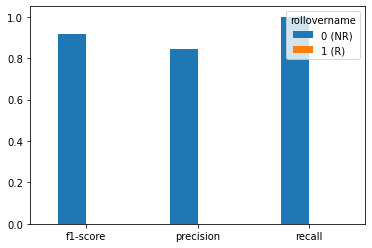

In [85]:
plot_cr(svms_cr)

Text(0.5, 1.0, 'Accuracy of the different 4 models')

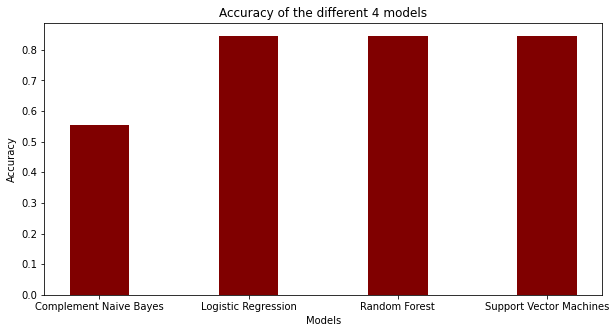

In [86]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(["Complement Naive Bayes", "Logistic Regression", "Random Forest", "Support Vector Machines"], 
        [cnb_cr["accuracy"], lreg_cr["accuracy"], rfc_cr["accuracy"], svms_cr["accuracy"]], color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of the different 4 models")

# Part-7: Interpretation
7.1) Visualize rollover risk distributions of the models for training and testing datasets separately. Report the visual results.<br>
**Hint**: Use ```predict_proba``` function of the fitted models.

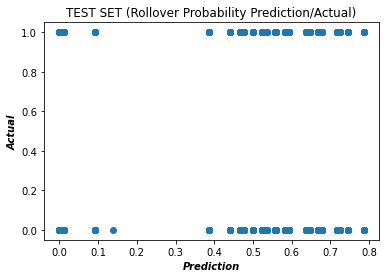

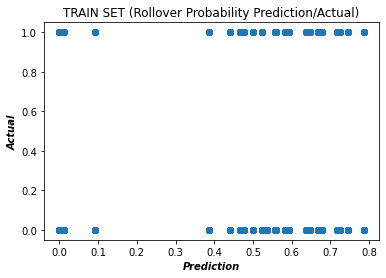

In [87]:
# Complement Naive Bayes

plt.xlabel("Prediction", fontweight="bold", style="italic")
plt.ylabel("Actual", fontweight="bold", style="italic")
plt.title("TEST SET (Rollover Probability Prediction/Actual)")
plt.scatter(cnb.predict_proba(x_test_final_selected_10)[:, 1], y_test.reset_index()["rollovername"])
plt.figure()
plt.xlabel("Prediction", fontweight="bold", style="italic")
plt.ylabel("Actual", fontweight="bold", style="italic")
plt.title("TRAIN SET (Rollover Probability Prediction/Actual)")
plt.scatter(cnb.predict_proba(x_train_final_selected_10)[:, 1], y_train.reset_index()["rollovername"])

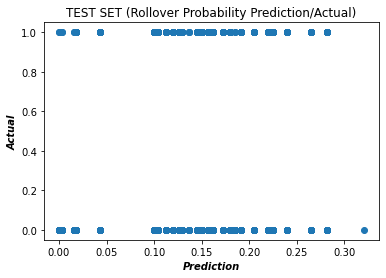

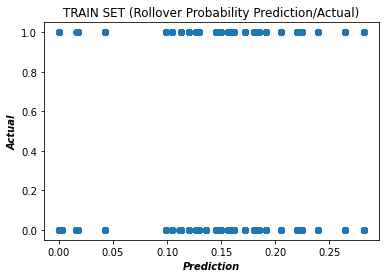

In [88]:
# Logistic Regression
plt.xlabel("Prediction", fontweight="bold", style="italic")
plt.ylabel("Actual", fontweight="bold", style="italic")
plt.title("TEST SET (Rollover Probability Prediction/Actual)")
plt.scatter(lreg.predict_proba(x_test_final_selected_10)[:, 1], y_test.reset_index()["rollovername"])
plt.figure()
plt.xlabel("Prediction", fontweight="bold", style="italic")
plt.ylabel("Actual", fontweight="bold", style="italic")
plt.title("TRAIN SET (Rollover Probability Prediction/Actual)")
plt.scatter(lreg.predict_proba(x_train_final_selected_10)[:, 1], y_train.reset_index()["rollovername"])

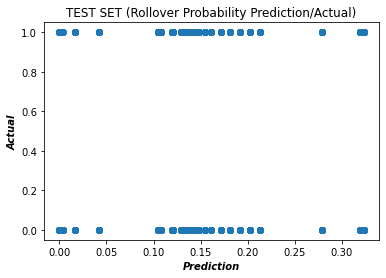

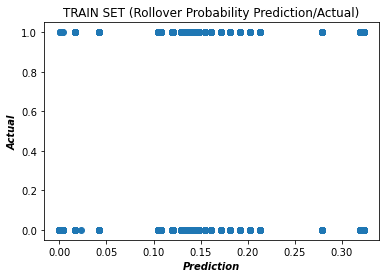

In [89]:
# Random Forest
plt.xlabel("Prediction", fontweight="bold", style="italic")
plt.ylabel("Actual", fontweight="bold", style="italic")
plt.title("TEST SET (Rollover Probability Prediction/Actual)")
plt.scatter(rfc.predict_proba(x_test_final_selected_10)[:, 1], y_test.reset_index()["rollovername"])
plt.figure()
plt.xlabel("Prediction", fontweight="bold", style="italic")
plt.ylabel("Actual", fontweight="bold", style="italic")
plt.title("TRAIN SET (Rollover Probability Prediction/Actual)")
plt.scatter(rfc.predict_proba(x_train_final_selected_10)[:, 1], y_train.reset_index()["rollovername"])

7.2) Visualize year-by-year rollover risk distributions by the predictions of the best model you determined. Interpret the results in the report.

In [ ]:
# YOUR CODE HERE

7.3) Determine the features which useful to explain the car rollover phenomenon.<br>
**Reminder**: Determine **at most 30** features. It is not saying that report 30 features. Maybe, after the top 20 features, others have much less importance. You should report a short-listed features.

You can follow several strategies:
- Using ```coef_``` attribute of linear models
- Using ```feature_log_prob_``` attribute of probabilistic models
- Using ```feature_importances_``` attribute of the decision-tree based models
- Using ```permutation_importance``` function of sklearn (**REQUIRED** to explain how it works in the report)
    
You can either rely on the best model or all models to determine the good features.
For example, if you have multiple successful models, you can determine the common important features for them. 
    
After the creating a short-listed features, you can ensure whether they are enough to explain the phenemona via observing performances of re-trained model(s) using only these features.

In [ ]:
# YOUR CODE HERE